In [150]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import pickle


%matplotlib inline

# Camera calibration
### Compute camera calibration parameters and pickle dump them 

In [ ]:
cal_images = glob.glob('./camera_cal/*.jpg')
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Step through the list and search for chessboard corners
for idx, fname in enumerate(cal_images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)



In [ ]:
test_image = mpimage.imread('./test_images/test1.jpg')
img_size = (test_image.shape[1], test_image.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open('camera_cal/camera_cal_pickle.p', 'wb'))



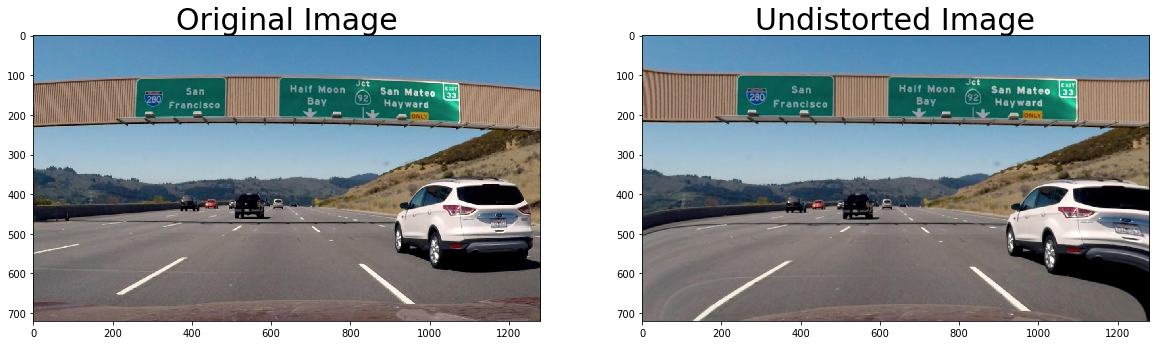

In [167]:
dst = cv2.undistort(test_image, mtx, dist, None, mtx)
mpimage.imsave('./writeup_images/test1_undist.jpg', dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)


# Load Camera matrix and distortion coeffs

In [17]:
camdata = pickle.load(open('./camera_cal/camera_cal_pickle.p', 'rb'))
mtx = camdata['mtx']
dist = camdata['dist']

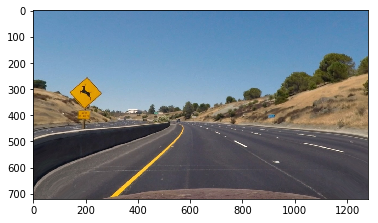

In [18]:
def undistort_image(img_arr, matrix, coeffs):
    return cv2.undistort(img_arr, matrix, coeffs, None, matrix)

# test on a sample image
plt.imshow(undistort_image(mpimage.imread('./test_images/test2.jpg'), mtx, dist))

# Image Perspective transform

### Hand picked source and destination points and Perspective transform matrices

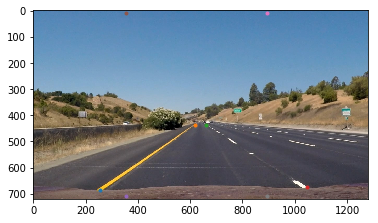

In [19]:
srcpts = np.float32([[254, 686], [617, 439], [661, 439], [1046, 676]])
dstpts = np.float32([[353, 718], [353, 10],  [894, 10], [894, 718]])


src_image = mpimage.imread('./test_images/straight_lines1.jpg')

plt.imshow(src_image)
plt.plot(254, 686, '.')
plt.plot(617, 439, '.')
plt.plot(661, 439, '.')
plt.plot(1046, 676, '.')

plt.plot(353, 710, '.')
plt.plot(353, 10, '.')
plt.plot(894, 10, '.')
plt.plot(894, 710, '.')


M = cv2.getPerspectiveTransform(srcpts, dstpts)
Minv = cv2.getPerspectiveTransform(dstpts, srcpts)


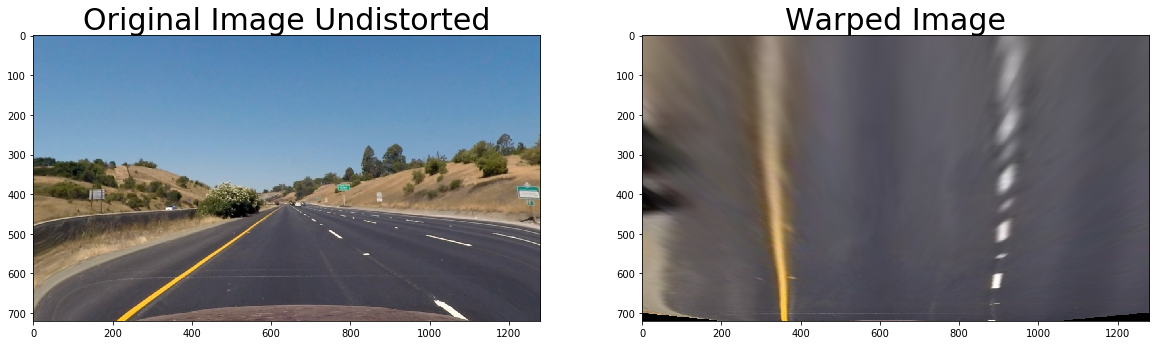

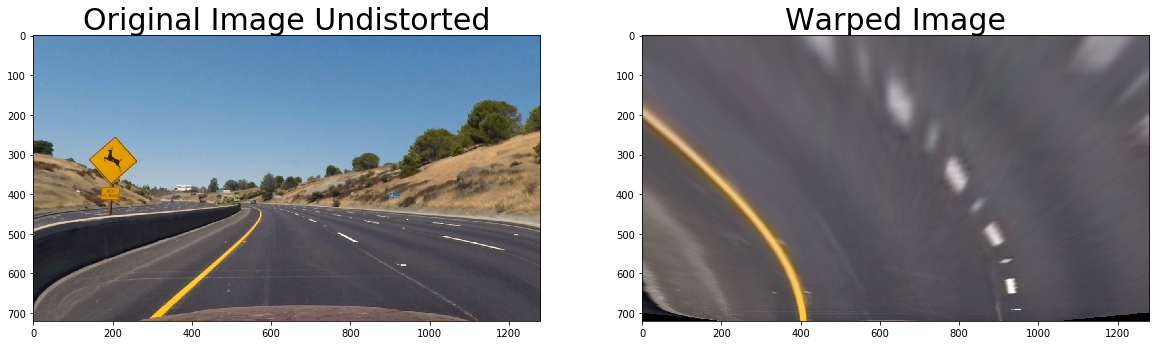

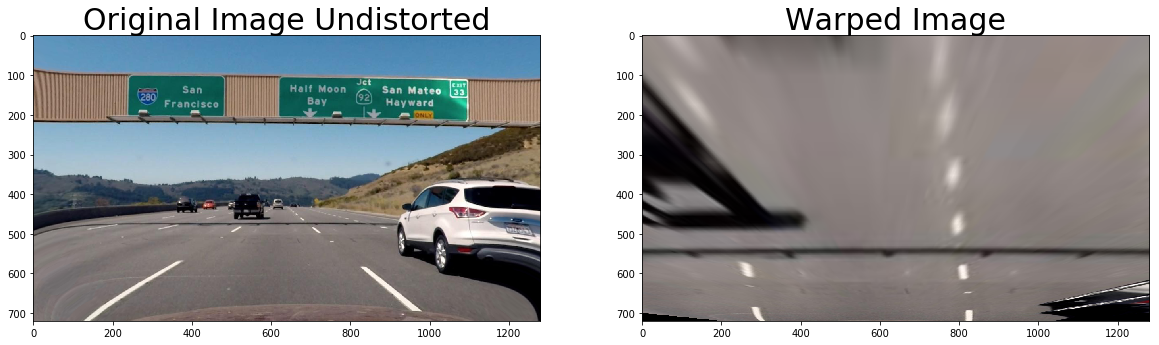

In [179]:
undist = undistort_image(src_image, mtx, dist)
warp_image = cv2.warpPerspective(undist, M, (src_image.shape[1], src_image.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Original Image Undistorted', fontsize=30)
ax2.imshow(warp_image)
ax2.set_title('Warped Image', fontsize=30)

curved = mpimage.imread('./test_images/test2.jpg')
undist = undistort_image(curved, mtx, dist)
warp_image = cv2.warpPerspective(undist, M, (curved.shape[1], curved.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Original Image Undistorted', fontsize=30)
ax2.imshow(warp_image)
ax2.set_title('Warped Image', fontsize=30)

other_image = mpimage.imread('./test_images/signs_vehicles_xygrad.jpg')
undist = undistort_image(other_image, mtx, dist)
warp_image = cv2.warpPerspective(undist, M, (curved.shape[1], curved.shape[0]))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Original Image Undistorted', fontsize=30)
ax2.imshow(warp_image)
ax2.set_title('Warped Image', fontsize=30)



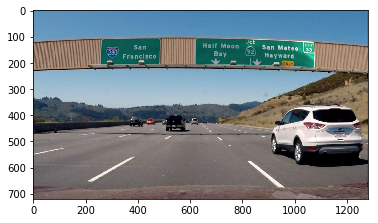

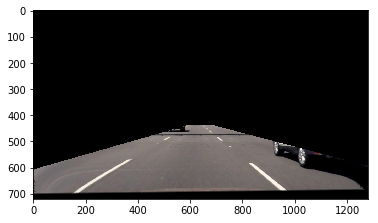

In [182]:
unwarp_image = cv2.warpPerspective(warp_image, Minv, (warp_image.shape[1], warp_image.shape[0]))
plt.figure()
plt.imshow(other_image)
plt.figure()
plt.imshow(unwarp_image)

In [184]:
def warp_image(imarr, matrix):
    cv2.warpPerspective(imarr, matrix, (imarr.shape[1], imarr.shape[0]))

# Gradient and Color Thresholding

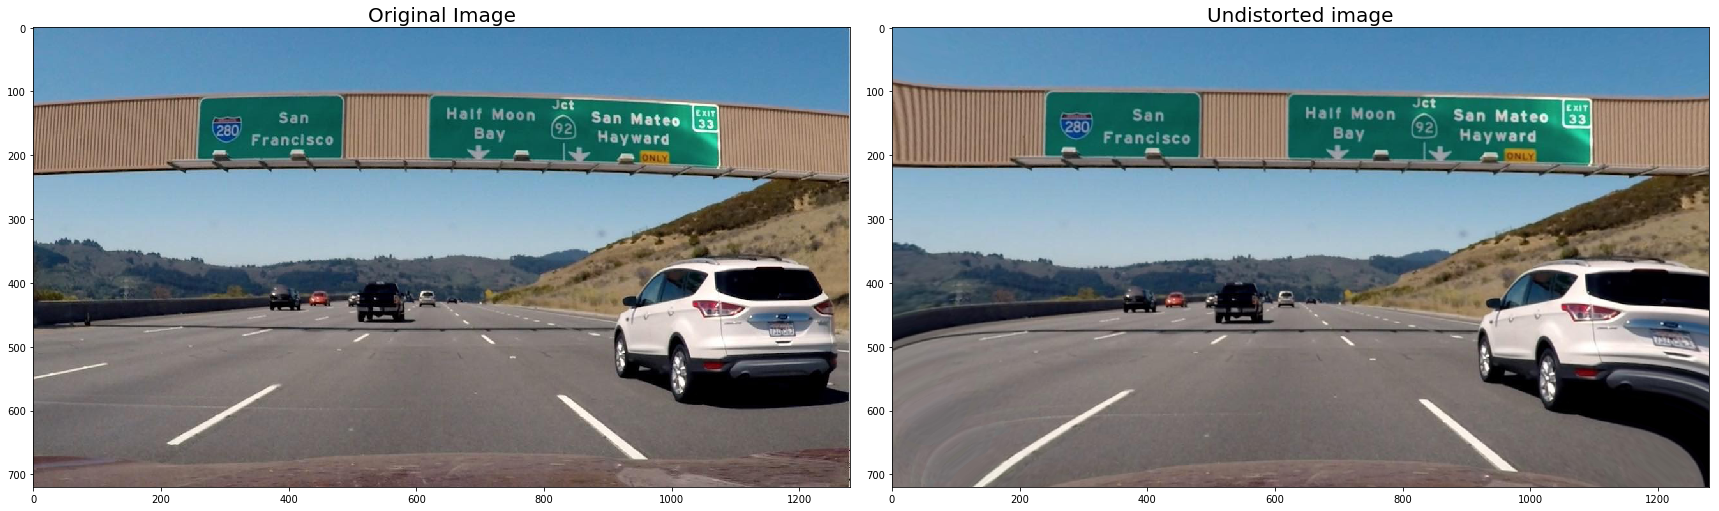

In [151]:
# Test image
orig_image = mpimage.imread('./test_images/signs_vehicles_xygrad.jpg')
image = undistort_image(orig_image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(image)
ax2.set_title('Undistorted image', fontsize=20)

In [154]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, kernel_size=3, hls=False):
    # Convert to grayscale
    if hls:
        hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = hls_image[:,:,1]
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(abs_sobel/np.max(abs_sobel)*255)
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output



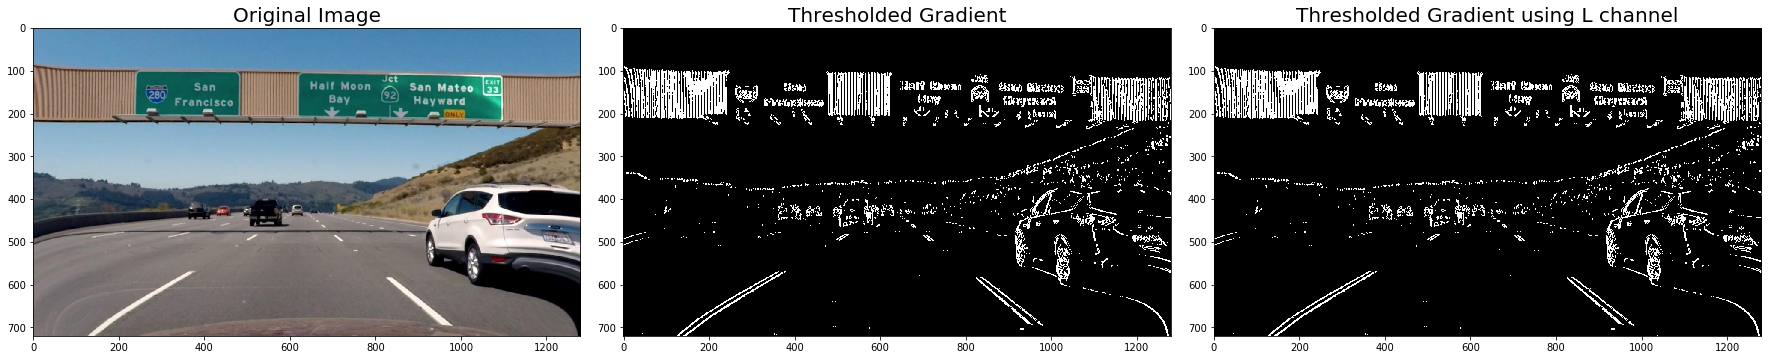

In [155]:
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
grad_binary_hls = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100, hls=True)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=20)
ax3.imshow(grad_binary_hls, cmap='gray')
ax3.set_title('Thresholded Gradient using L channel', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

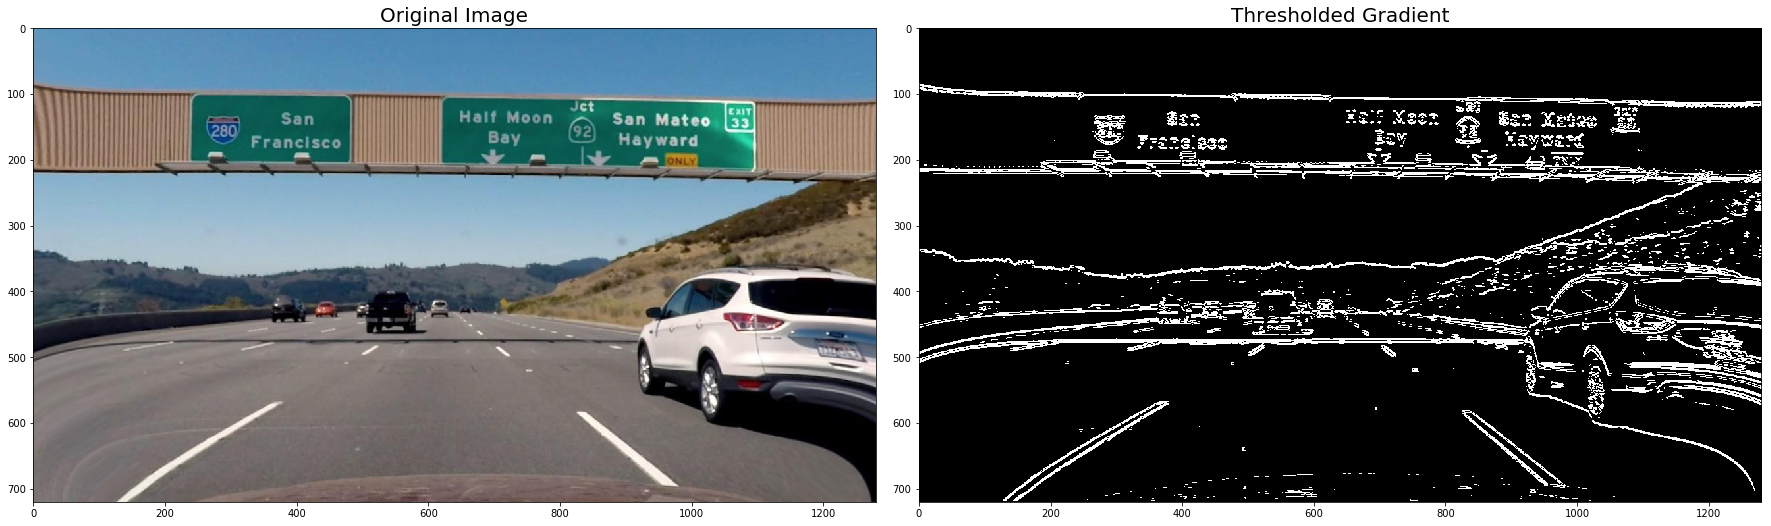

In [157]:
# Run the function
grad_binary = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [158]:
def magnitude_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    gradmag = (gradmag/np.max(gradmag)*255).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


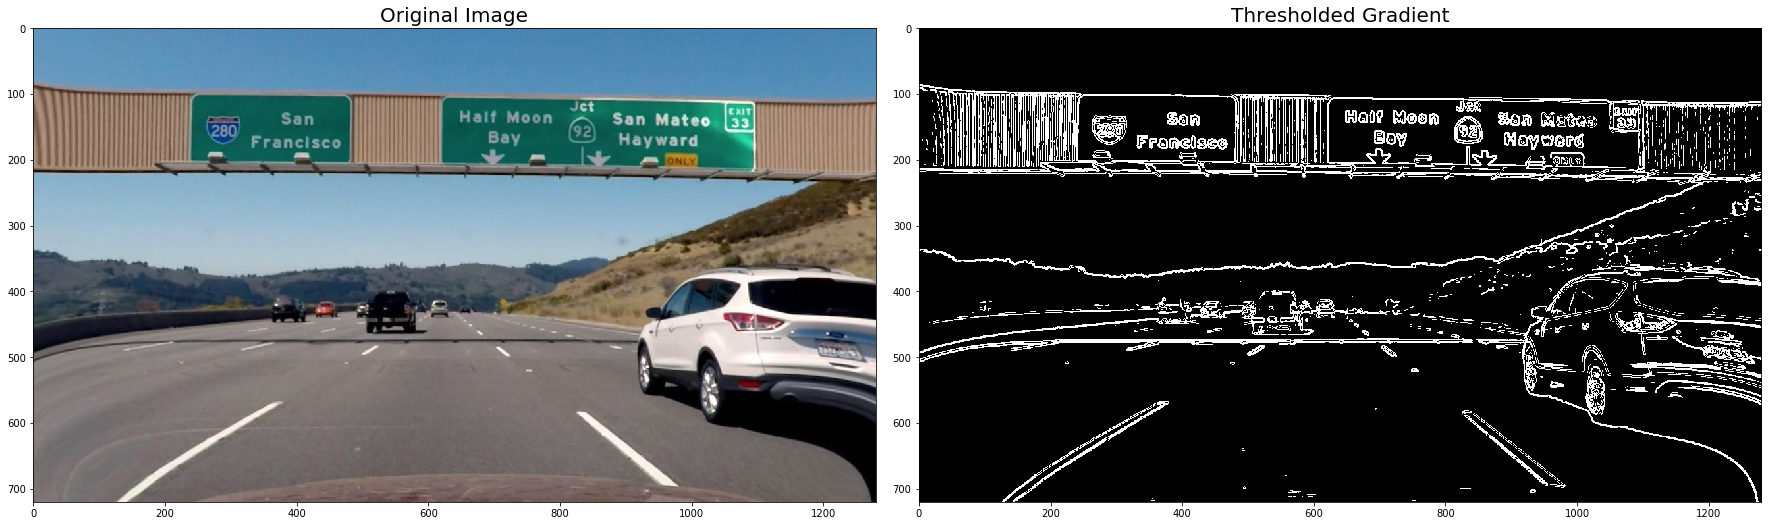

In [159]:
# Run the function
mag_binary = magnitude_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [160]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

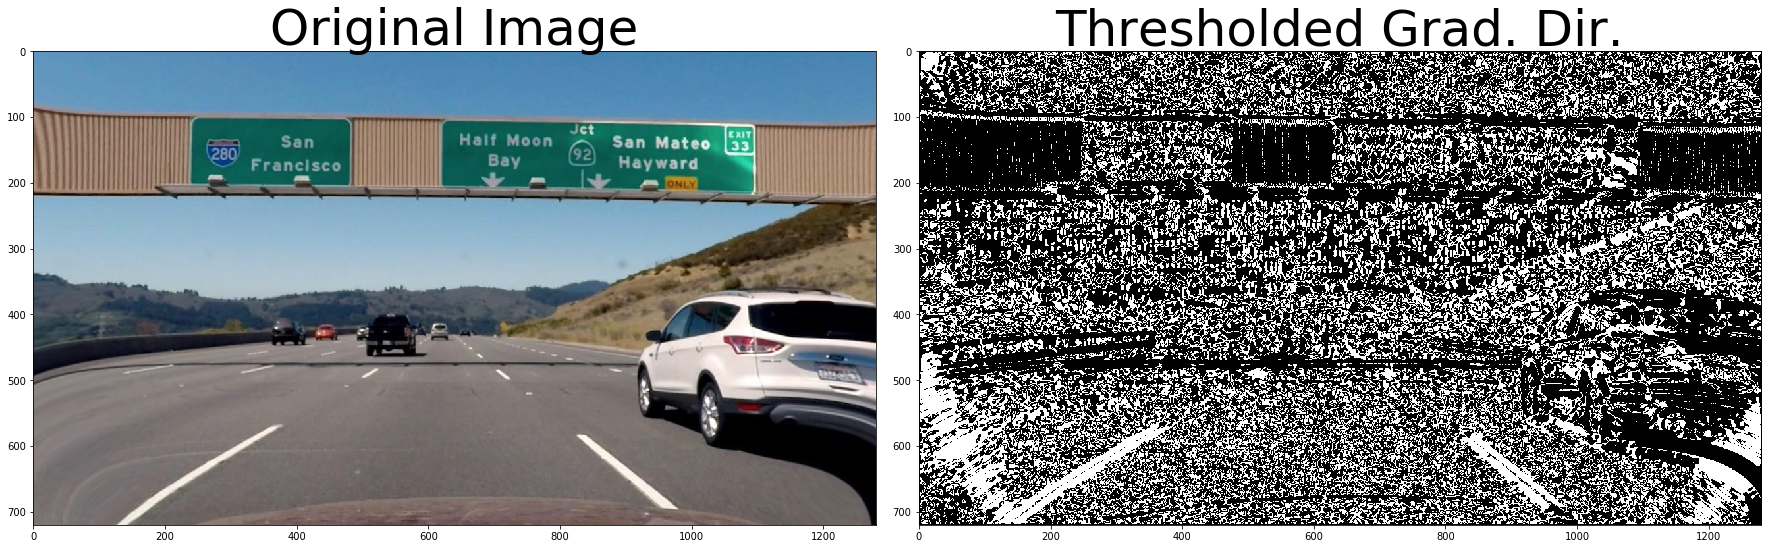

In [161]:
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combined direction, magnitude and absolute gradients

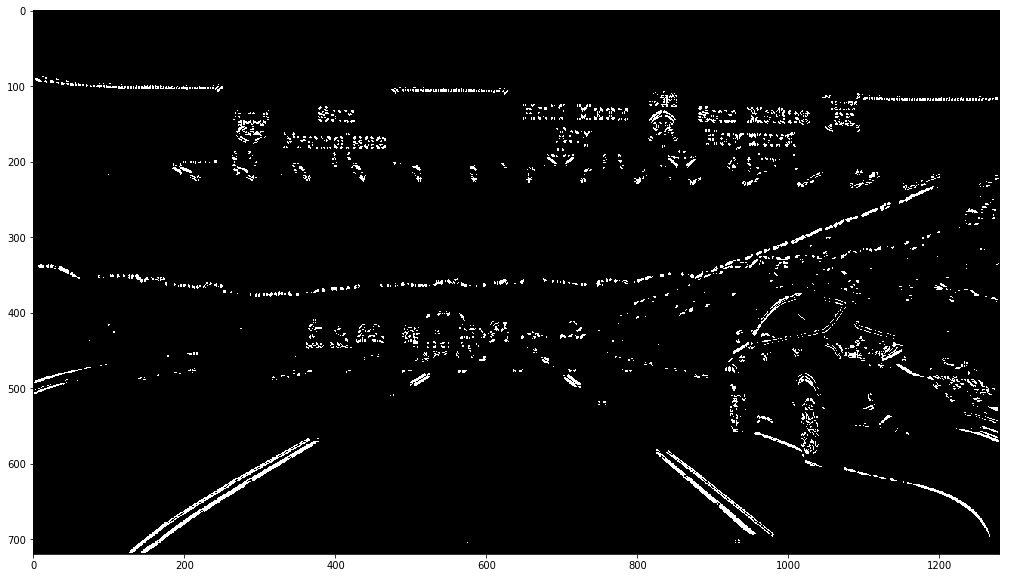

In [168]:
gradx_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100, kernel_size=7)
grady_binary = abs_sobel_thresh(image, orient='y', thresh_min=30, thresh_max=100, kernel_size=7)
mag_binary = magnitude_thresh(image, sobel_kernel=5, mag_thresh=(40, 100))
dir_binary = dir_threshold(image, sobel_kernel=7, thresh=(.9, 1.3))

combined = combined = np.zeros_like(dir_binary)
combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure(figsize=(20,10))
plt.imshow(combined, cmap='gray')
plt.imsave('./writeup_images/signs_vehicles_xygrad_binary.jpg', combined, cmap='gray')


### HLS color space

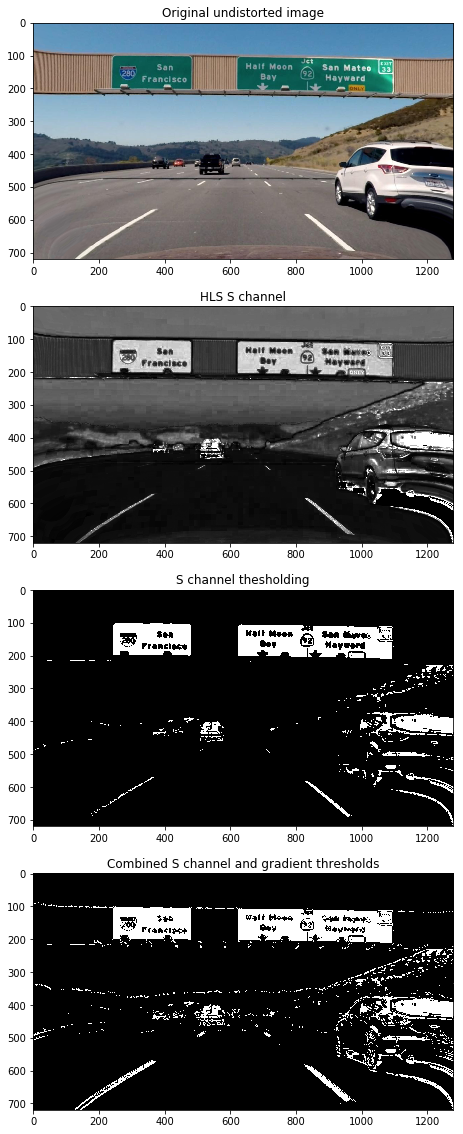

In [170]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

s_thresh_min = 130
s_thresh_max = 255

s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= 255)] = 1

color_and_gradient = np.zeros_like(s_channel)
color_and_gradient[(s_binary == 1) | (combined == 1)] = 1
plt.imsave('./writeup_images/gradient_and_color_thresh.jpg', color_and_gradient, cmap='gray')

f, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

axes[0].set_title('Original undistorted image')
axes[0].imshow(image)
axes[1].set_title('HLS S channel')
axes[1].imshow(s_channel, cmap='gray')
axes[2].set_title('S channel thesholding')
axes[2].imshow(s_binary, cmap='gray')
axes[3].set_title('Combined S channel and gradient thresholds')
axes[3].imshow(color_and_gradient, cmap='gray')

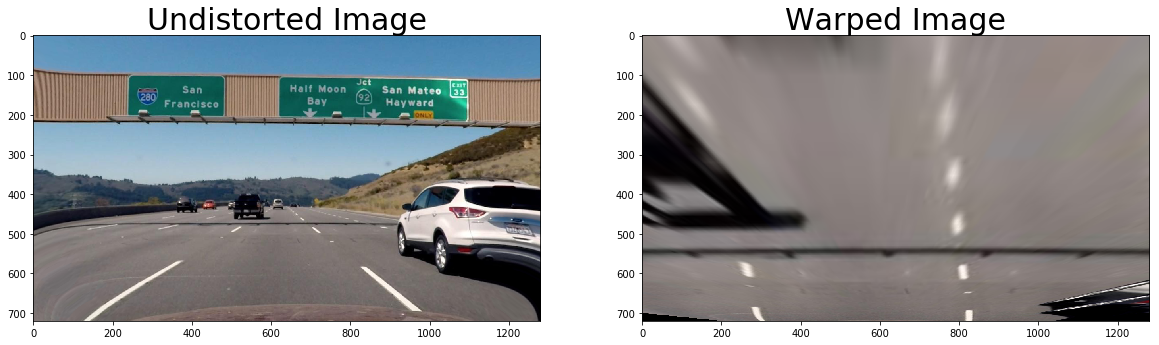

In [175]:
warp_image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warp_image)
ax2.set_title('Warped Image', fontsize=30)

